<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HAP.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0        time  open  high   low  close  volume
0              0  2015-01-05  3.37  3.41  3.37   3.37   32350
1              1  2015-01-06  3.33  3.45  3.28   3.45   56110
2              2  2015-01-07  3.45  3.49  3.37   3.37  144310
3              3  2015-01-08  3.41  3.45  3.37   3.37  102940
4              4  2015-01-09  3.37  3.45  3.37   3.41  149160
...          ...         ...   ...   ...   ...    ...     ...
2414        2414  2024-09-13  4.26  4.28  4.26   4.27    7100
2415        2415  2024-09-16  4.15  4.25  4.15   4.17   51100
2416        2416  2024-09-17  4.17  4.23  4.17   4.19   67000
2417        2417  2024-09-18  4.19  4.24  4.19   4.19   15600
2418        2418  2024-09-19  4.25  4.29  4.21   4.21    5100

[2419 rows x 7 columns]>

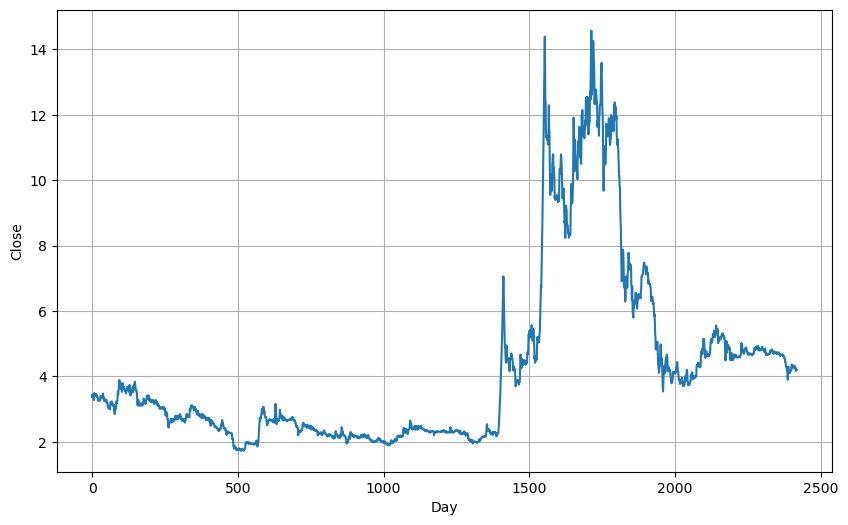

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HAP.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [6]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
62/62 [==============================] - 25s 16ms/step - loss: 37.0218 - mae: 37.5168
Epoch 2/100
62/62 [==============================] - 1s 16ms/step - loss: 6.1127 - mae: 6.5904
Epoch 3/100
62/62 [==============================] - 1s 19ms/step - loss: 0.9876 - mae: 1.3972
Epoch 4/100
62/62 [==============================] - 1s 18ms/step - loss: 0.7072 - mae: 1.0952
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 0.7346 - mae: 1.1257
Epoch 6/100
62/62 [==============================] - 1s 19ms/step - loss: 0.6175 - mae: 0.9955
Epoch 7/100
62/62 [==============================] - 1s 20ms/step - loss: 0.5729 - mae: 0.9468
Epoch 8/100
62/62 [==============================] - 1s 20ms/step - loss: 0.5714 - mae: 0.9514
Epoch 9/100
62/62 [==============================] - 1s 19ms/step - loss: 0.4860 - mae: 0.8490
Epoch 10/100
62/62 [==============================] - 1s 20ms/step - loss: 0.4657 - mae: 0.8235
Epoch 11/100
62/62 [==========================

62/62 [==============================] - 2s 25ms/step - loss: 0.0962 - mae: 0.3219
Epoch 87/100
62/62 [==============================] - 2s 25ms/step - loss: 0.0994 - mae: 0.3305
Epoch 88/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0952 - mae: 0.3238
Epoch 89/100
62/62 [==============================] - 2s 24ms/step - loss: 0.0962 - mae: 0.3262
Epoch 90/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0911 - mae: 0.3173
Epoch 91/100
62/62 [==============================] - 2s 24ms/step - loss: 0.0919 - mae: 0.3235
Epoch 92/100
62/62 [==============================] - 2s 25ms/step - loss: 0.0943 - mae: 0.3266
Epoch 93/100
62/62 [==============================] - 2s 28ms/step - loss: 0.0950 - mae: 0.3249
Epoch 94/100
62/62 [==============================] - 2s 28ms/step - loss: 0.1016 - mae: 0.3354
Epoch 95/100
62/62 [==============================] - 2s 27ms/step - loss: 0.0995 - mae: 0.3245
Epoch 96/100
62/62 [==============================] -

In [8]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

14/14 [==============================] - 4s 24ms/step


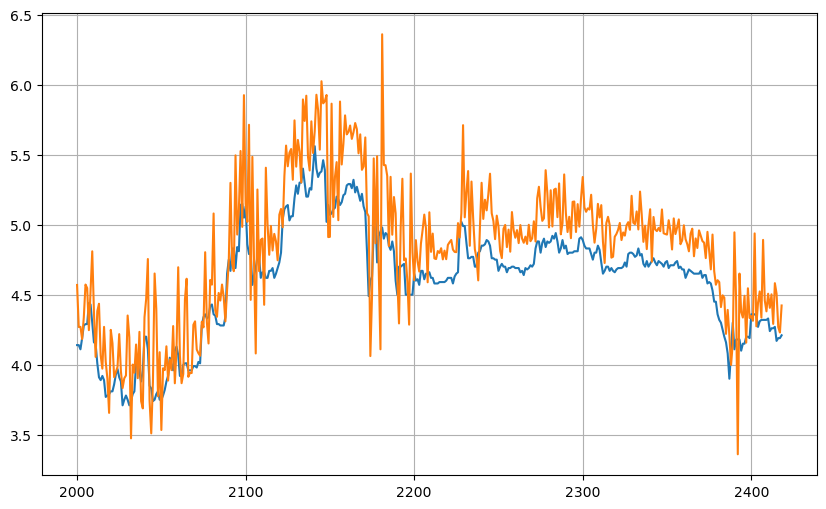

[4.5692925 4.2689595 4.2703185 4.183108  4.3394017 4.5722904 4.5471196
 4.246678  4.5223093 4.8095946 4.37958   4.0558267 4.3825974 4.435042
 4.066551  3.9719973 4.270214  4.0199537 3.898031  3.6560867 4.248739
 4.153869  3.9105897 3.9478216 3.9844115 4.218321  3.9531415 3.8333972
 3.9027188 3.9232795 4.3512588 4.196495  3.474382  4.001001  3.9430175
 4.1442323 3.9039855 4.2346063 3.7393932 3.6882925 4.3384767 4.47132
 4.754565  3.7447426 3.509832  3.8757985 4.651192  4.398761  3.7747476
 4.089326  3.5340075 3.9746318 3.961416  4.1313863 3.8868043 4.0369396
 3.9614444 4.275936  3.867442  4.110438  4.695702  4.0645037 3.868187
 3.9337802 4.4666295 4.6137514 3.9135342 3.9426494 3.9405663 4.284904
 4.3095875 4.1085844 4.0816965 4.0638733 4.306701  4.266602  4.8030677
 4.3044095 4.1516175 4.6054935 4.5715036 5.0796247 4.3873644 4.3422346
 4.512239  4.4583263 4.5723143 4.4824753 4.309622  4.5350885 4.7364163
 5.2983227 4.7233706 4.667798  5.4946485 4.92923   5.108819  5.525737
 4.9838815 5.

In [9]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)